Use the simple SNR model from "Design considerations for low-margin elastic optical networks in the nonlinear regime" Savory et al. with an added white Gaussian noise term, designed to alleviate the problem of significantly reducing the predictive variance of the model:
$SNR = \frac{1}{aP^{-1} + bP^2} + c$, where $a$ and $b$ determine the strength of the linear and nonlinear noise contributions and $c$ represents the TRx NSR.


Focus on compensation for lack of data with physical models. This is a better approach than trying to predict outside of the range of the dataset, as kernel-based methods like GPs are never going to succeed in predicting far beyond the data like that. 

**Key idea**: bottleneck in the future is likely to be the data acquistion (as verified in our lab), and thus we want to be able to minimise the size of the data needed for inference...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel as W
from scipy.optimize import curve_fit
from numpy.random import normal
from simple_model import simple_model
font = { 'family' : 'sans-serif',
                'weight' : 'normal',
                'size'   : 14}
matplotlib.rc('font', **font)

In [2]:
data_dir = '/Users/Kate/physical_gp_josh/physics_enhanced_GPs/pch_sweep_data/'
snr = np.genfromtxt(open(str(data_dir) + "pchexpsnrsam100.csv", "r"), delimiter=",", dtype =float)[21:60]
pch = np.genfromtxt(open(str(data_dir) + "pchexppchsam100.csv", "r"), delimiter=",", dtype =float)[21:60]
# snr = np.genfromtxt(open(str(data_dir) + "pchexpsnrsam300.csv", "r"), delimiter=",", dtype =float)
# pch = np.genfromtxt(open(str(data_dir) + "pchexppchsam300.csv", "r"), delimiter=",", dtype =float)

In [3]:
down_sample_factor = 3  # currently doing nothing 
snr = np.array([snr[i] for i in range(len(snr)) if i % down_sample_factor == 0])
pch = np.array([pch[i] for i in range(len(pch)) if i % down_sample_factor == 0])
snr_lin = 10**(snr/10)
pch_lin = 1e-3*10**(pch/10)

In [4]:
len(pch)

13

Select a subset of the data to examine what happens when we fit with fewer datapoints. 

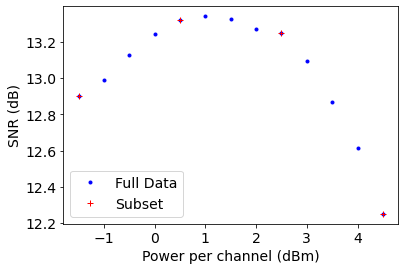

In [5]:
snr_sub = np.copy(snr)[::4]
pch_sub = np.copy(pch)[::4]
plt.plot(pch, snr, 'b.', label='Full Data')
plt.plot(pch_sub, snr_sub, 'r+', label='Subset')
plt.xlabel("Power per channel (dBm)")
plt.ylabel("SNR (dB)")
plt.legend()
plt.show()

Instead see what happens when we use the physical model to infer the function in places that we dont have much data, perhaps because we can only measure a constrained number of points and thus we choose to measure more where we expect there to be more variation a priori.

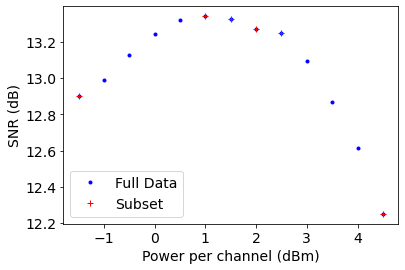

In [99]:
snr_sub = np.array([snr[0], snr[5], snr[6], snr[7], snr[8],  snr[-1]])
pch_sub = np.array([pch[0], pch[5], pch[6], pch[7], pch[8],  pch[-1]])
plt.plot(pch, snr, 'b.', label='Full Data')
plt.plot(pch_sub, snr_sub, 'r+', label='Subset')
plt.xlabel("Power per channel (dBm)")
plt.ylabel("SNR (dB)")
plt.legend()
plt.show()

In [100]:
sim_model = simple_model()

In [101]:
opt_vals = sim_model.fit(pch.reshape(len(pch),), snr.reshape(len(pch),), init_guess = np.array([1e-5, 1e3, 1e0]))

In [102]:
a_opt, b_opt, c_opt = opt_vals[0]
snr_sim = sim_model.predict(pch, a_opt, b_opt, c_opt)
print(a_opt)
print(b_opt)
print(c_opt)

8.822107559780359e-05
19173.253494589633
11.784028710416118


Parameter 1 std dev estimates

In [103]:
a_opt_err, b_opt_err, c_opt_err = np.sqrt(np.diag(opt_vals[1]))
print(a_opt_err)
print(b_opt_err)
print(c_opt_err)

4.377771987739969e-06
1334.1221357503516
0.46763941431873113


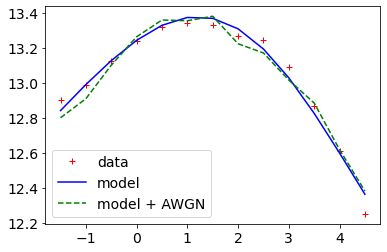

In [104]:
snr_sim_noise = snr_sim.reshape(len(snr_sim),) + np.random.normal(0, 0.03, len(pch))
plt.plot(pch, snr, 'r+', label='data')
plt.plot(pch, snr_sim, 'b-', label='model')
plt.plot(pch, snr_sim_noise, 'g--', label='model + AWGN')
plt.legend()
plt.show()

Generate physical model targets for use in hyperparameter optimisation.

In [129]:
a = np.linspace(pch[0], pch[4], 4)
b = np.linspace(pch[9], pch[-1], 4)
pch_phys = np.concatenate((a, b), axis=0)

In [130]:
num_points_phys = 8 #len(snr)
#pch_phys = np.linspace(pch[0], pch[-1], num_points_phys).reshape(-1,1) 
#snr_phys_test = sim_model.predict(pch_test, a_opt, b_opt, c_opt).reshape(-1,1)
snr_phys = sim_model.predict(pch_phys, a_opt, b_opt, c_opt).reshape(len(pch_phys),) + np.random.normal(0, 0.03, len(pch_phys))
snr_phys = snr_phys.reshape(-1,1)

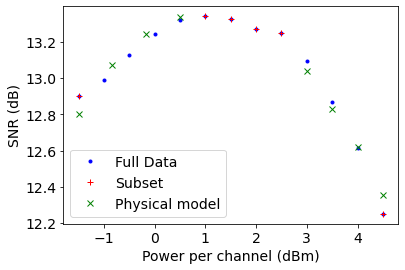

In [131]:
plt.plot(pch, snr, 'b.', label='Full Data')
plt.plot(pch_sub, snr_sub, 'r+', label='Subset')
plt.plot(pch_phys, snr_phys, 'gx', label='Physical model')
plt.xlabel("Power per channel (dBm)")
plt.ylabel("SNR (dB)")
plt.legend()
plt.show()

In [132]:
# PHYSICS-ENHANCED GP
pch_sub = pch_sub.reshape(-1, 1)  # needed for SK learn input
#pch_predict = np.linspace(pch_shifted[0], pch_shifted[-1] + 1.0)
pch = pch.reshape(-1,1)
snr_sub = snr_sub.reshape(-1,1)
kernel_sk = C(1, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5)) +  W(1, (1e-8,1e5))
gpr_phys = GaussianProcessRegressor(kernel=kernel_sk, n_restarts_optimizer = 20, normalize_y=True)
gpr_phys.fit_phys(pch_sub, pch_phys, snr_sub, snr_phys)
#print("Optimised kernel: %s" % gpr.kernel_)
mu_sk_phys, std_sk_phys = gpr_phys.predict(pch, return_std=True)
std_sk_phys = np.reshape(std_sk_phys,(np.size(std_sk_phys), 1)) 
theta_phys = gpr_phys.kernel_.theta
lml_phys = gpr_phys.log_marginal_likelihood()
mu_sk_p2_phys = mu_sk_phys + 2*std_sk_phys 
mu_sk_n2_phys = mu_sk_phys - 2*std_sk_phys 

In [133]:
# NORMAL GP 
pch_sub = pch_sub.reshape(-1, 1)  # needed for SK learn input
pch = pch.reshape(-1, 1)  # needed for SK learn input
snr_sub = snr_sub.reshape(-1,1)
kernel_sk =   C(1, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5)) + W(1, (1e-8,1e5))
gpr = GaussianProcessRegressor(kernel=kernel_sk, n_restarts_optimizer = 20, normalize_y=True)
gpr.fit(pch_sub, snr_sub)
#print("Optimised kernel: %s" % gpr.kernel_)
mu_sk, std_sk = gpr.predict(pch, return_std=True)
std_sk = np.reshape(std_sk,(np.size(std_sk), 1)) 
theta = gpr.kernel_.theta
lml = gpr.log_marginal_likelihood()
mu_sk_p2 = mu_sk + 2*std_sk 
mu_sk_n2 = mu_sk - 2*std_sk 

/Users/Kate/sk_learn_fork_josh/scikit-learn/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-08. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


In [134]:
# NORMAL GP FULL DATASET 
pch = pch.reshape(-1, 1)  # needed for SK learn input
snr = snr.reshape(-1,1)
kernel_sk =   C(1, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5)) + W(1, (1e-8,1e5))
gpr_f = GaussianProcessRegressor(kernel=kernel_sk, n_restarts_optimizer = 20, normalize_y=True)
gpr_f.fit(pch, snr)
#print("Optimised kernel: %s" % gpr.kernel_)
mu_sk_f, std_sk_f = gpr_f.predict(pch, return_std=True)
std_sk_f = np.reshape(std_sk_f,(np.size(std_sk_f), 1)) 
theta_f = gpr_f.kernel_.theta
lml_f = gpr_f.log_marginal_likelihood()
mu_sk_f_p2 = mu_sk_f + 2*std_sk_f 
mu_sk_f_n2 = mu_sk_f - 2*std_sk_f 

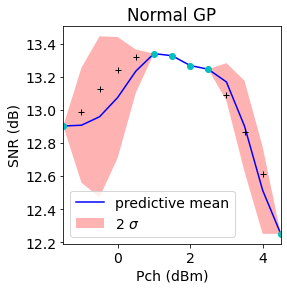

In [135]:
f, ax = plt.subplots()
ax.plot(pch, mu_sk, 'b-', label = 'predictive mean')
ax.plot(pch, snr,'k+')
ax.plot(pch_sub, snr_sub,'co')
#ax.plot(pch_shifted, snr_phys, 'g--', label = 'GN model')
ax.fill(np.concatenate([pch, pch[::-1]]),
            np.concatenate([mu_sk_p2,
                            (mu_sk_n2)[::-1]]),
            alpha=0.3, fc='r', ec='None', label='2 $\sigma$')
plt.xlim(pch[0], pch[-1])
plt.xlabel("Pch (dBm)")
plt.ylabel("SNR (dB)")
plt.title("Normal GP")
plt.legend()
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
plt.savefig('normal_GP.pdf', dpi=200,bbox_inches='tight')
plt.show()

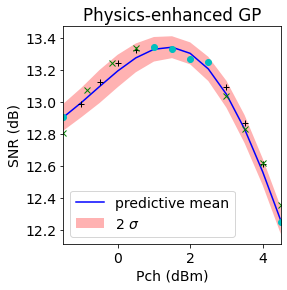

In [136]:
f, ax = plt.subplots()
ax.plot(pch, mu_sk_phys, 'b-', label = 'predictive mean')
ax.plot(pch, snr,'k+')
ax.plot(pch_sub, snr_sub,'co')
ax.plot(pch_phys, snr_phys, 'gx')
#ax.plot(pch_shifted, snr_phys, 'g--', label = 'GN model')
ax.fill(np.concatenate([pch, pch[::-1]]),
            np.concatenate([mu_sk_p2_phys,
                            (mu_sk_n2_phys)[::-1]]),
            alpha=0.3, fc='r', ec='None', label='2 $\sigma$')
plt.xlim(pch[0], pch[-1])
plt.xlabel("Pch (dBm)")
plt.ylabel("SNR (dB)")
plt.title("Physics-enhanced GP")
plt.legend()
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
plt.savefig('physics_enhanced_GP.pdf', dpi=200,bbox_inches='tight')
plt.show()

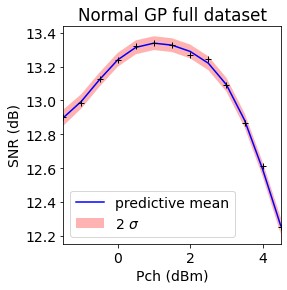

In [119]:
f, ax = plt.subplots()
ax.plot(pch, mu_sk_f, 'b-', label = 'predictive mean')
ax.plot(pch, snr,'k+')
#ax.plot(pch_shifted, snr_phys, 'g--', label = 'GN model')
ax.fill(np.concatenate([pch, pch[::-1]]),
            np.concatenate([mu_sk_f_p2,
                            (mu_sk_f_n2)[::-1]]),
            alpha=0.3, fc='r', ec='None', label='2 $\sigma$')
plt.xlim(pch[0], pch[-1])
plt.xlabel("Pch (dBm)")
plt.ylabel("SNR (dB)")
plt.title("Normal GP full dataset")
plt.legend()
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
plt.savefig('normal_GP_full.pdf', dpi=200,bbox_inches='tight')
plt.show()

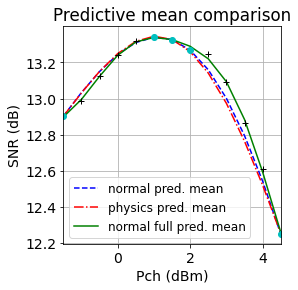

In [89]:
f, ax = plt.subplots()
ax.plot(pch, mu_sk, 'b--', label = 'normal pred. mean')
ax.plot(pch, mu_sk_phys, 'r-.', label = 'physics pred. mean')
ax.plot(pch, mu_sk_f, 'g-', label = 'normal full pred. mean')
ax.plot(pch, snr,'k+')
ax.plot(pch_sub, snr_sub,'co')
plt.xlim(pch[0], pch[-1])
plt.xlabel("Pch (dBm)")
plt.ylabel("SNR (dB)")
plt.title("Predictive mean comparison")
plt.legend(prop={'size': 12})
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.grid()
f.patch.set_facecolor('w')
plt.savefig('pred_mean_comp.pdf', dpi=200,bbox_inches='tight')
plt.show()

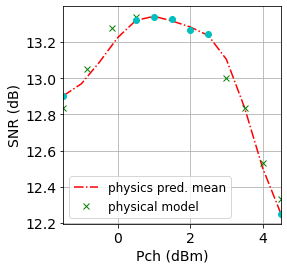

In [62]:
f, ax = plt.subplots()
ax.plot(pch, mu_sk_phys, 'r-.', label = 'physics pred. mean')
ax.plot(pch_phys, snr_phys, 'gx', label = 'physical model')
#ax.plot(pch, snr,'k+')
ax.plot(pch_sub, snr_sub,'co')
plt.xlim(pch[0], pch[-1])
plt.xlabel("Pch (dBm)")
plt.ylabel("SNR (dB)")
#plt.title("Physical model comparison")
plt.legend(prop={'size': 12})
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.grid()
f.patch.set_facecolor('w')
plt.savefig('physical_model_test.pdf', dpi=200,bbox_inches='tight')
plt.show()

In [20]:
max(std_sk)

array([0.42202705])

In [21]:
max(std_sk_phys)

array([0.05624589])

In [22]:
np.exp(theta)  # mu, l, sigma: kernel specified as mu**2 * RBF(l**2) + W(sigma)

array([4.82057705e-01, 2.11414396e-05, 5.17942307e-01])

In [23]:
np.exp(theta_phys)  # mu, l, sigma: kernel specified as mu**2 * RBF(l**2) + W(sigma)

array([4.62478991, 2.78032671, 0.00536826])